# **Final Assigment: Yahoo Answers Topic**

---

# Part 0: Dataset

In this project, we will be using the **Yahoo Topics** dataset for the tasks below.

We’ll start by loading it using the Hugging Face `datasets` library.

This dataset contains a large number of questions and their respective answers in topics such as sports, business & finance, society & culture, science & mathematics, family & relationships, computers & the internet, and more.


In [2]:
from datasets import load_dataset
import pandas as pd

# Load the dataset
train_dataset = load_dataset("community-datasets/yahoo_answers_topics", split="train")
test_dataset = load_dataset("community-datasets/yahoo_answers_topics", split="test")

# Convert to pandas DataFrame for easier handling
df = pd.concat([train_dataset.to_pandas(), test_dataset.to_pandas()]).reset_index(drop=True)
#df = df.rename(columns={"text": "document", "label": "true_label"})

# Show basic info
print(f"Dataset size: {len(df)} documents")
df.head()

Dataset size: 1460000 documents


,id,topic,question_title,question_content,best_answer
0,0,4,why doesn't an optical mouse work on a glass t...,or even on some surfaces?,Optical mice use an LED and a camera to rapidl...
1,1,5,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...
2,2,2,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...
3,3,6,How many planes Fedex has?,I heard that it is the largest airline in the ...,according to the www.fedex.com web site:\nAir ...
4,4,6,"In the san francisco bay area, does it make se...",the prices of rent and the price of buying doe...,renting vs buying depends on your goals. <br /...


Below are the libraries we will use to deal with this dataset

In [ ]:
# I imported a library that detects the language of the text.
!pip install langdetect
from langdetect import detect
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

from collections import defaultdict
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords




[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


# Part 1: Problem Setup

**Objective**:

The goal of this project is to build and evaluate models for automated topic classification on the Yahoo Answers dataset. This dataset contains user-submitted questions categorized into broad topics. By establishing a baseline performance through random and rule-based classifiers, and reviewing the state of the art, we aim to understand the challenges of this task and prepare for building more sophisticated models in later stages


## Bibliography and SOA


**Main Objective**: The task is a multi-class text classification. We will be classifying topics as it is often conceived a natural first supervised learning task due to its clear label structure and real-world applicability. Additionally, there are multiple research papers available acting as a baseline. 


**Business Case**:  In practice, it's common for businesses to receive a large number of customer questions through support channels. These questions can cover a wide variety of topics — from product functionality and billing issues to technical problems and general inquiries. This diversity makes customer service more complex, as each question typically needs to be routed to the appropriate department manually.

A department handling all topics at once would be inefficient because it would slow down response times, overload general support staff, and increase the chance of miscommunication or misrouting. Without this topic-awareness, questions may bounce between departments, leading to customer frustration and operational delays.

By implementing a topic classification system, businesses can automatically categorize incoming queries and send them directly to the relevant team. This allows specialized agents to address issues more quickly and effectively, improving both customer satisfaction and internal workflow efficiency. Only after a question is correctly identified in terms of its topic can it be answered in a relevant and high-quality manner.

**State of the Art**: 
Due to the datasets popularity, there have been a lot of attempts in utilizing this text data for classification purposes. This includes different methodologies, from rule-based classification, SVM, Neural Networks and Large Language models. Below are some papers that explore it in different ways, showcasing how different methodologies yield slightly different results and how it got better over time with more suffisticated models:

- Zhang et al. (2015) introduced the Yahoo Answers dataset as part of a suite of large-scale text classification benchmarks. They compared traditional models like n-gram TF-IDF + Logistic Regression against deep neural networks, including character-level CNNs. This work already highlighted the limitations of shallow models and the potential of deep architectures in capturing richer language patterns.
https://arxiv.org/abs/1509.01626


- Kumar et al. (2017) applied hierarchical SVM-based classifiers to Yahoo Answers questions, modeling the structure of categories to improve accuracy over flat classification.
https://www.researchgate.net/publication/224345610_Applying_Question_Classification_to_Yahoo_Answers


- Overall, recent benchmarks on PapersWithCode show that modern models like transformer (BERT, RoBERTa, and DistilBERT) significantly outperform earlier approaches. Fine-tuned RoBERTa-base models can achieve nearly 80% accuracy, compared to ~70% for traditional methods.
https://paperswithcode.com/sota/text-classification-on-yahoo-answers


| Rank | Model             | Accuracy (%) | Paper Title                                                                 | Year |
|------|-------------------|--------------|------------------------------------------------------------------------------|------|
| 1    | BERT-ITPT-FiT     | 77.62        | How to Fine-Tune BERT for Text Classification?                              | 2019 |
| 2    | DRNN              | 76.26        | Disconnected Recurrent Neural Networks for Text Categorization              | 2018 |
| 3    | DELTA (HAN)       | 75.10        | DELTA: A DEep learning based Language Technology plAtform                   | 2019 |
| 4    | EXAM              | 74.80        | Explicit Interaction Model towards Text Classification                      | 2018 |
| 5    | DNC+CUW           | 74.30        | Learning to Remember More with Less Memorization                            | 2019 |
| 6    | ULMFiT (Small data)| 74.30       | Sampling Bias in Deep Active Classification: An Empirical Study             | 2019 |
| 7    | CCCapsNet         | 73.85        | Compositional Coding Capsule Network with K-Means Routing for Text Classification | 2018 |
| 8    | SWEM-concat       | 73.53        | Baseline Needs More Love: On Simple Word-Embedding-Based Models and Associated Pooling Mechanisms | 2018 |
| 9    | FastText          | 72.30        | Bag of Tricks for Efficient Text Classification                             | 2016 |
| 10   | Seq2CNN (50)      | 55.39        | Abstractive Text Classification Using Sequence-to-convolution Neural Networks | 2018 |


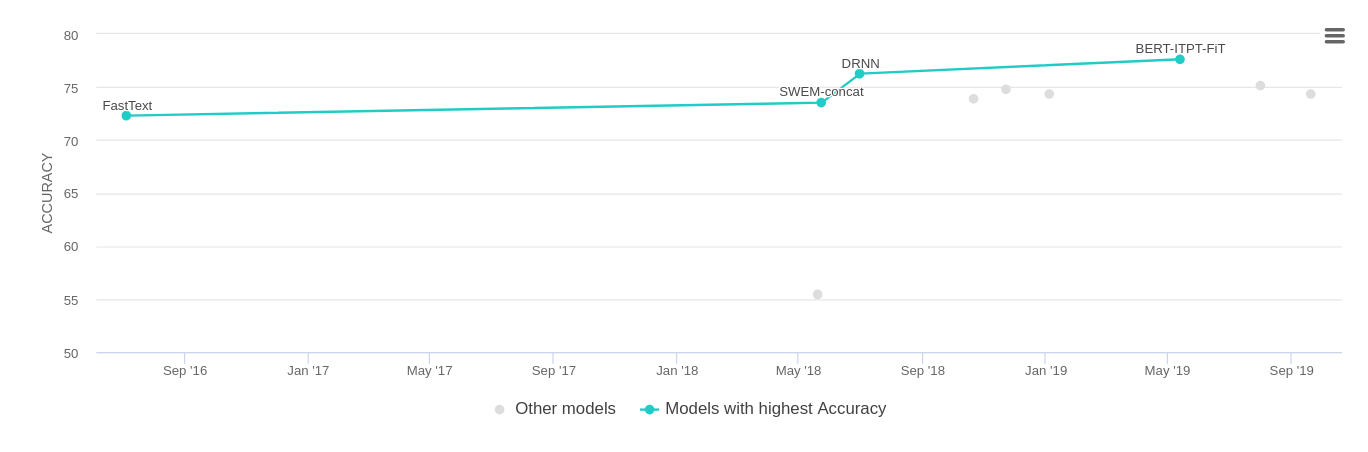

**Figure 1:** Accuracy of top models on the Yahoo Answers text classification task. Source: [Papers With Code – Yahoo Answers](https://paperswithcode.com/sota/text-classification-on-yahoo-answers)

## Dataset Description


The dataset used is **Yahoo Answers Topics**, a large dataset (1.4M rows) containing community question and answer pairs across 10 topic categories. Each sample includes a question title, question content, best answer, and a numeric label for the topic.

Below is a summary including dataset size, class distribution, and average lengths of the question and answer texts.

Total samples: 1460000
Number of classes: 10
Average question length (words): 21.66
Average answer length (words): 59.18
Average question length (characters): 116.57
Average answer length (characters): 345.07
Minimum question length (words): 0
Minimum answer length (words): 0
Maximum question length (words): 910
Maximum answer length (words): 1169
Missing questions: 0
Missing answers: 0

Class distribution:
Society & Culture: 146000
Science & Mathematics: 146000
Health: 146000
Education & Reference: 146000
Computers & Internet: 146000
Sports: 146000
Business & Finance: 146000
Entertainment & Music: 146000
Family & Relationships: 146000
Politics & Government: 146000


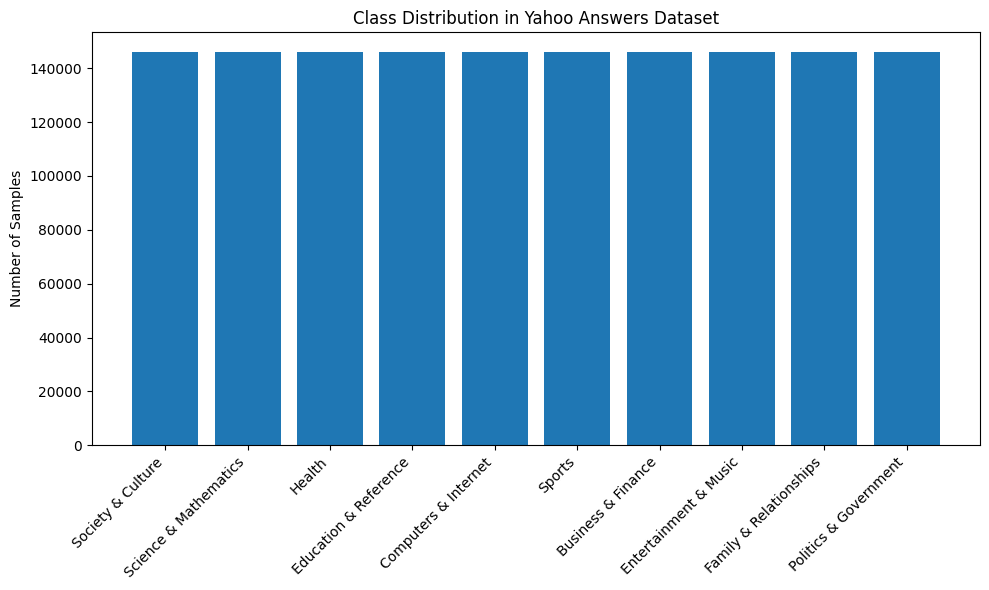

In [ ]:
# Descriptive statistics
dataset_size = len(df)
class_names = train_dataset.features['topic'].names
class_distribution = df['topic'].value_counts().sort_index()
class_counts_named = {class_names[i]: class_distribution[i] for i in range(len(class_names))}

avg_question_length = df['question_content'].apply(lambda x: len(x.split())).mean()
avg_answer_length = df['best_answer'].apply(lambda x: len(x.split())).mean()
avg_question_length_char = df['question_content'].apply(lambda x: len(x)).mean()
avg_answer_length_char = df['best_answer'].apply(lambda x: len(x)).mean()
min_question_length = df['question_content'].apply(lambda x: len(x.split())).min()
min_answer_length = df['best_answer'].apply(lambda x: len(x.split())).min()
max_question_length = df['question_content'].apply(lambda x: len(x.split())).max()
max_answer_length = df['best_answer'].apply(lambda x: len(x.split())).max()
missing_questions = df['question_content'].isnull().sum()
missing_answers = df['best_answer'].isnull().sum()

# Print summary
print("Total samples:", dataset_size)
print("Number of classes:", len(class_names))
print("Average question length (words):", round(avg_question_length, 2))
print("Average answer length (words):", round(avg_answer_length, 2))
print("Average question length (characters):", round(avg_question_length_char, 2))
print("Average answer length (characters):", round(avg_answer_length_char, 2))
print("Minimum question length (words):", min_question_length)
print("Minimum answer length (words):", min_answer_length)
print("Maximum question length (words):", max_question_length)
print("Maximum answer length (words):", max_answer_length)
print("Missing questions:", missing_questions)
print("Missing answers:", missing_answers)
print("\nClass distribution:")
for cls, count in class_counts_named.items():
    print(f"{cls}: {count}")

# Plot class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_distribution)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Yahoo Answers Dataset")
plt.tight_layout()
plt.show()


Overall, we have 1 460 000 samples in this dataset. Furhtermore, it is evenly distributed across all 10 classes, with **146,000 samples per class**, making it **balanced** — a desirable property for training classification models without introducing bias toward more frequent classes.

In terms of text statistics:
- The **average question content length** is approximately **22 words**.
- The **average best answer length** is around **59 words**.
- Minimum and maximum word counts range from very short single-sentence questions to long multi-sentence answers (optional to mention if you've calculated them).

This difference in length suggests that answers tend to be significantly more verbose than the questions, which is expected in a Q&A format. The balanced class distribution and large sample size make this dataset well-suited for benchmarking text classification models.

No missing values or duplicates were observed in the provided training split. However, there appears to be some kind of empty string answers and questions, as the minimum answer and question length is 0. Therefore, we filter these out of the dataframe below

Empty questions: 658761
Empty answers: 25606
Minimum question length (words): 1
Minimum answer length (words): 1
Questions with 3 or fewer words: 37678
Answers with 3 or fewer words: 45856


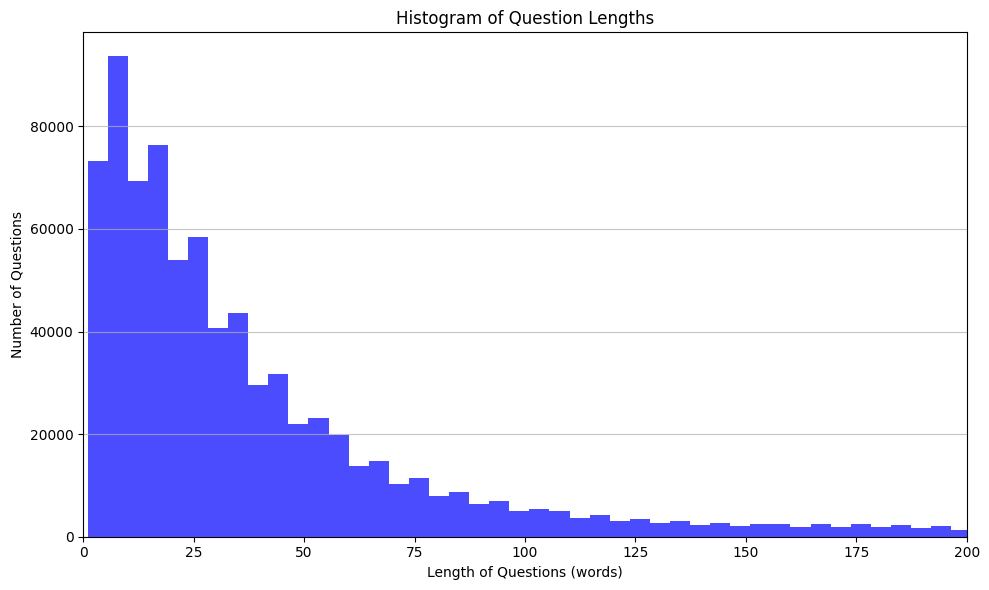

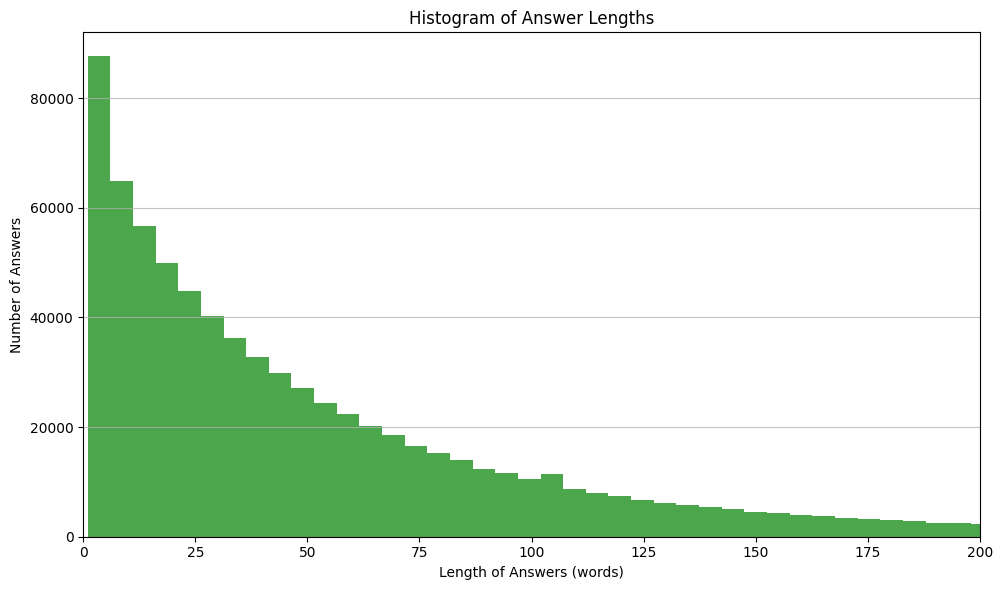

In [4]:
empty_questions = df['question_content'].apply(lambda x: x.strip() == "")
empty_answers = df['best_answer'].apply(lambda x: x.strip() == "")

print("Empty questions:", empty_questions.sum())
print("Empty answers:", empty_answers.sum())

df = df[~empty_questions & ~empty_answers]

# Check for empty questions and answers again
min_question_length = df['question_content'].apply(lambda x: len(x.split())).min()
min_answer_length = df['best_answer'].apply(lambda x: len(x.split())).min()

print("Minimum question length (words):", min_question_length)
print("Minimum answer length (words):", min_answer_length)

short_questions = df['question_content'].apply(lambda x: len(x.split()) <= 3).sum()
print(f"Questions with 3 or fewer words: {short_questions}")

# Count answers with 3 or fewer words
short_answers = df['best_answer'].apply(lambda x: len(x.split()) <= 3).sum()
print(f"Answers with 3 or fewer words: {short_answers}")


#plot a histogram of the length of the questions
plt.figure(figsize=(10, 6))
plt.hist(df['question_content'].apply(lambda x: len(x.split())), bins=200, alpha=0.7, color='blue')
plt.xlabel("Length of Questions (words)")
plt.ylabel("Number of Questions")
plt.title("Histogram of Question Lengths")
plt.grid(axis='y', alpha=0.75)
plt.xlim(0, 200)
plt.tight_layout()
plt.show()
#plot a histogram of the length of the answers
plt.figure(figsize=(10, 6))
plt.hist(df['best_answer'].apply(lambda x: len(x.split())), bins=200, alpha=0.7, color='green')
plt.xlabel("Length of Answers (words)")
plt.ylabel("Number of Answers")
plt.title("Histogram of Answer Lengths")
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.xlim(0, 200)
plt.show()

We can see that we have quite a few cases where questions or answers are extremely short — specifically, 37,678 questions and 45,856 answers contain three words or fewer. After filtering out completely empty entries, the minimum question and answer lengths increased to 1 word. However, some of these very short entries likely still contain low-information or meaningless text (e.g., "help", "why?", "okay").

Despite this, we choose not to remove these cases, for a few reasons:

- First, their presence reflects the natural noise of user-generated content, which models in production settings are likely to encounter.

- Second, the dataset remains large and balanced, so these outliers are unlikely to skew the overall learning process.

- Finally, short or vague questions may still contain subtle topic cues (e.g., a question like "Windows issue" may still be clearly technical).

For these reasons, we retain the short samples and proceed with the cleaned dataset, accepting a small degree of noise as part of the task's inherent complexity.

Finally, we will check which languages we are dealing with! It can be helpful when it comes to preprocessing techniques or stopword removals!

For analytical purposes to check the language distribution, we will use a subset of only 100 000 samples to avoid high computational times. We will also use this subset for the wordcloud below!

In [ ]:
# Function detect language
def safe_detect(text):
    try:
        return detect(text) if isinstance(text, str) and text.strip() else "unknown"
    except:
        return "error"
#create new column
sample_df = df.sample(100000, random_state=42)
sample_df["lang"] = sample_df["question_content"].apply(safe_detect)
language_counts = print(sample_df["lang"].value_counts())


print(language_counts)



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
lang
en       94963
fr         637
af         523
error      418
nl         355
cy         281
de         257
it         257
no         234
so         220
tl         191
ca         180
da         171
pt         145
ro         144
es         127
id         118
et         113
vi          98
pl          78
sv          64
hr          60
sw          60
fi          52
sq          48
tr          42
sl          38
hu          34
sk          30
lt          21
cs          20
lv          11
ar           4
ru           2
he           1
uk           1
el           1
zh-cn        1
Name: count, dtype: int64
None


We can see that our corpus is predominantly in English, which means our classifier will likely also learn English language patterns.
We acknowledge that there is the possibility to filter to only English content to reduce the noise. Nevertheless, we will carry on including everything for now and potentially adress if deemed necessary.

## Random Classifier Performance

A random classifier assigns a class label to each sample by randomly selecting from the available topic classes. 
Random means we basically toss a coin, so if we have 1 class and 1 sample it will be correct 50% of the tosses. This can also be calculated for many samples. As long as the balance of the classes remain the same. If we had 1 sample and for classes it would be 25%. 

Since the Yahoo Answers dataset is balanced across these 10 classes, the expected performance of such a classifier is:

$
\frac{1}{10} = 0.10 \text{, so } 10\%
$

We will confirm this through a simple simulation below.

In [10]:
# Simulate random predictions
num_samples = len(df)
num_classes = 10
random_preds = np.random.randint(0, num_classes, size=num_samples)

# True labels
true_labels = df['topic']

# Accuracy of random predictions
random_accuracy = accuracy_score(true_labels, random_preds)
print(f"Simulated Random Classifier Accuracy: {random_accuracy:.4f}")

Simulated Random Classifier Accuracy: 0.1005


We can confirm that our calculation is correct!

## Baseline Implementation

[nltk_data] Downloading package stopwords to /home/oliver/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


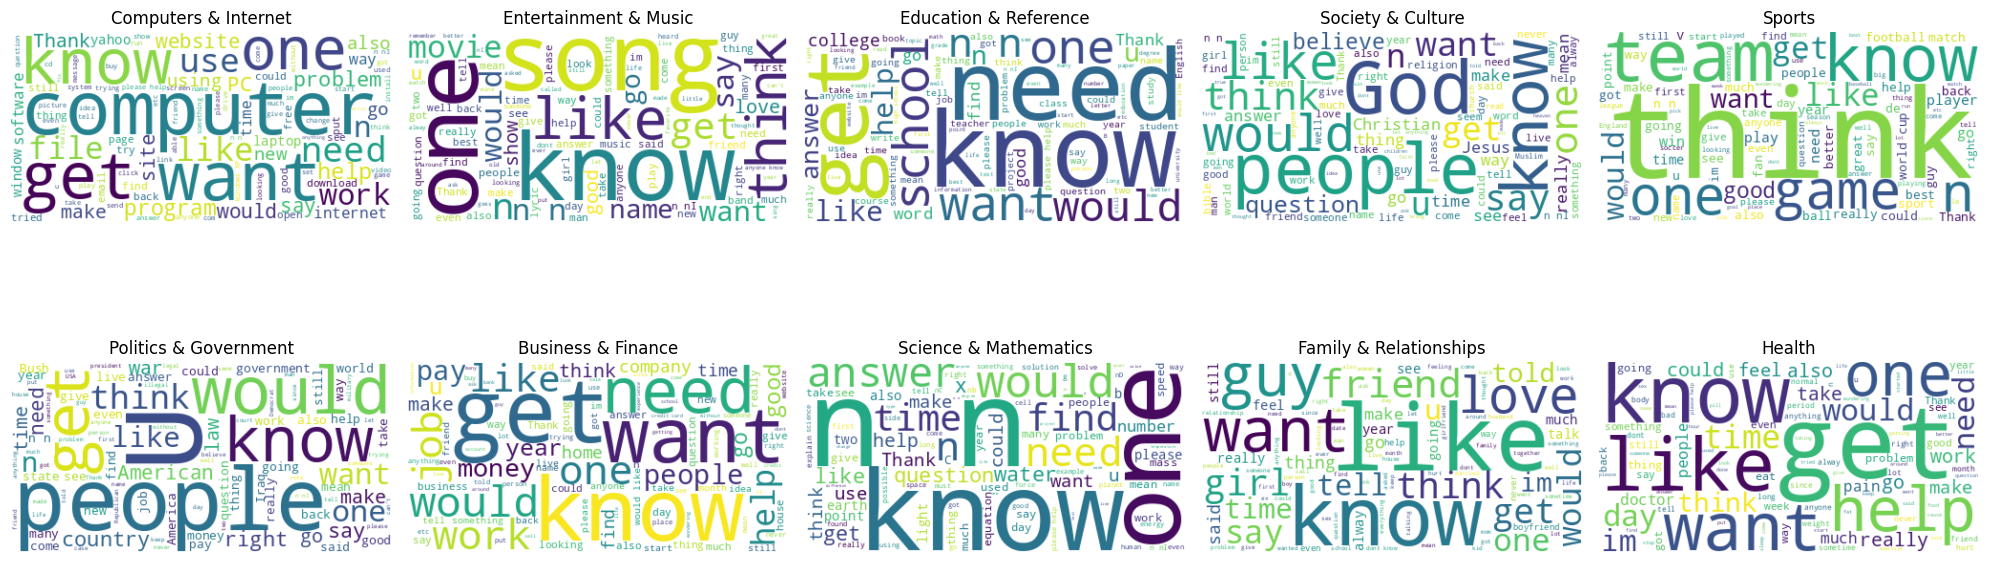

In [12]:
# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
# Get label names from above
label_names = class_names

# Aggregate question content by topic
label_text = defaultdict(str)
for text, label in zip(sample_df['question_content'], sample_df['topic']):
    label_text[label] += ' ' + text

# Generate and plot word clouds
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
axs = axs.flatten()

for idx, (label, text) in enumerate(label_text.items()):
    wordcloud = WordCloud(
        stopwords=stop_words,
        background_color='white',
        max_words=100
    ).generate(text)
    
    axs[idx].imshow(wordcloud, interpolation='bilinear')
    axs[idx].set_title(f"{label_names[label]}", fontsize=12)
    axs[idx].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Define keywords for each class
rules = {
    "Health": ["doctor", "medicine", "pain", "symptom"],
    "Computers & Internet": ["windows", "wifi", "laptop", "computer", "browser"],
    "Politics & Government": ["election", "government", "president", "law", "senate"],
    "Sports": ["game", "score", "team", "football", "league"],
    "Science & Mathematics": ["math", "science", "chemistry", "physics", "equation"],
    "Education & Reference": ["school", "college", "university", "study", "homework"],
    "Business & Finance": ["money", "business", "finance", "investment", "stock"],
    "Entertainment & Music": ["movie", "music", "concert", "band", "album"],
    "Family & Relationships": ["marriage", "relationship", "family", "friend", "love"],
    "Travel & Places": ["travel", "trip", "vacation", "hotel", "destination"],
    "Other": ["help", "question", "advice", "information", "support"],
}

# Simple classifier
def classify_rule_based(text):
    text = text.lower()
    for label, keywords in rules.items():
        if any(word in text for word in keywords):
            return label
    return "Other"  # fallback class if no match

NameError: name 'label_names' is not defined